In [1]:
from google.colab import files
uploaded = files.upload()


Saving tech_layoffs_location.csv to tech_layoffs_location (1).csv
Saving tech_layoffs_Q2_2024.csv to tech_layoffs_Q2_2024 (1).csv
Saving tech_layoffs_til_Q1_2024.csv to tech_layoffs_til_Q1_2024 (1).csv
Saving tech_layoffs.xlsx to tech_layoffs (1).xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
# Load CSV and Excel files
location_data = pd.read_csv('tech_layoffs_location.csv')
q2_2024_data = pd.read_csv('tech_layoffs_Q2_2024.csv')
q1_2024_data = pd.read_csv('tech_layoffs_til_Q1_2024.csv')
excel_data = pd.ExcelFile('tech_layoffs.xlsx')

# Read all sheets from the Excel file
excel_sheets = {sheet_name: excel_data.parse(sheet_name) for sheet_name in excel_data.sheet_names}

# Check the first few rows of each dataset
print(location_data.head())
print(q2_2024_data.head())
print(q1_2024_data.head())
for sheet, data in excel_sheets.items():
    print(f"\nSheet: {sheet}")
    print(data.head())



                                                              location_HQ;Region;State;Country;latitude;longitude;;
Adelaide;;;Australia;-34                         9281805;138                                           5999312;;   
Agoura Hills;;California;USA;34                  14791;-118                                            7657042;;   
Ahmedabad;;;India;23                             0216238;72                                            5797068;;   
Alameda;San Francisco Bay Area;California;USA;37 6090291;-121                                           899142;;   
Amsterdam;;;Netherlands;52                       3730796;4                                             8924534;;   
   #        Company    Location_HQ                  Region       State  \
0  1  Tamara Mellon    Los Angeles                     NaN  California   
1  2   HopSkipDrive    Los Angeles                     NaN  California   
2  3    Panda Squad  San Francisco  San Francisco Bay Area  California   
3  4    

In [4]:
# Split the column into as many parts as possible based on semicolon delimiters
split_data = location_data['location_HQ;Region;State;Country;latitude;longitude;;'].str.split(';', expand=True)

# Check the structure of the split data
print(split_data.head())
print(split_data.shape)  # Confirm the number of columns after splitting

# Assign generic column names based on actual number of columns in the split
column_count = split_data.shape[1]
split_data.columns = [f'Column_{i+1}' for i in range(column_count)]

# Display the result
print(split_data.head())


                                                                     0 1 2
Adelaide;;;Australia;-34                         9281805;138   5999312    
Agoura Hills;;California;USA;34                  14791;-118    7657042    
Ahmedabad;;;India;23                             0216238;72    5797068    
Alameda;San Francisco Bay Area;California;USA;37 6090291;-121   899142    
Amsterdam;;;Netherlands;52                       3730796;4     8924534    
(197, 3)
                                                              Column_1  \
Adelaide;;;Australia;-34                         9281805;138   5999312   
Agoura Hills;;California;USA;34                  14791;-118    7657042   
Ahmedabad;;;India;23                             0216238;72    5797068   
Alameda;San Francisco Bay Area;California;USA;37 6090291;-121   899142   
Amsterdam;;;Netherlands;52                       3730796;4     8924534   

                                                              Column_2  \
Adelaide;;;Australia;-

In [5]:
# Split 'Column_1' dynamically
split_result = split_data['Column_1'].str.split(';', expand=True)

# Check the result of the split
print(split_result.head())
print(split_result.columns)

# Dynamically extract columns based on their presence
# Use .iloc[:, index] to avoid KeyError if index numbers are not column names
split_data['location_HQ'] = split_result.iloc[:, 0] if split_result.shape[1] > 0 else None
split_data['Region'] = split_result.iloc[:, 1] if split_result.shape[1] > 1 else None
split_data['State'] = split_result.iloc[:, 2] if split_result.shape[1] > 2 else None
split_data['Country'] = split_result.iloc[:, 3] if split_result.shape[1] > 3 else None
split_data['latitude'] = pd.to_numeric(split_result.iloc[:, 4], errors='coerce') if split_result.shape[1] > 4 else None

# Drop unnecessary columns
split_data = split_data.drop(columns=['Column_1', 'Column_2', 'Column_3'], errors='ignore')

# Display the cleaned data
print(split_data.head())
print(split_data.info())




                                                                     0
Adelaide;;;Australia;-34                         9281805;138   5999312
Agoura Hills;;California;USA;34                  14791;-118    7657042
Ahmedabad;;;India;23                             0216238;72    5797068
Alameda;San Francisco Bay Area;California;USA;37 6090291;-121   899142
Amsterdam;;;Netherlands;52                       3730796;4     8924534
RangeIndex(start=0, stop=1, step=1)
                                                              location_HQ  \
Adelaide;;;Australia;-34                         9281805;138      5999312   
Agoura Hills;;California;USA;34                  14791;-118       7657042   
Ahmedabad;;;India;23                             0216238;72       5797068   
Alameda;San Francisco Bay Area;California;USA;37 6090291;-121      899142   
Amsterdam;;;Netherlands;52                       3730796;4        8924534   

                                                              Region State 

In [6]:
# Reset the MultiIndex to columns
location_data_reset = location_data.reset_index()
print(location_data_reset.head())  # Check the structure of the reset DataFrame
print(location_data_reset.columns)  # List the column names

                                            level_0       level_1  \
0                          Adelaide;;;Australia;-34   9281805;138   
1                   Agoura Hills;;California;USA;34    14791;-118   
2                              Ahmedabad;;;India;23    0216238;72   
3  Alameda;San Francisco Bay Area;California;USA;37  6090291;-121   
4                        Amsterdam;;;Netherlands;52     3730796;4   

  location_HQ;Region;State;Country;latitude;longitude;;  
0                                          5999312;;     
1                                          7657042;;     
2                                          5797068;;     
3                                           899142;;     
4                                          8924534;;     
Index(['level_0', 'level_1',
       'location_HQ;Region;State;Country;latitude;longitude;;'],
      dtype='object')


In [7]:
# Adjust this based on the actual column name from inspection
column_to_split = location_data_reset.columns[0]  # Use the correct column name or index
print(column_to_split)  # Verify the column name to split

# Apply splitting to the correct column
split_result = location_data_reset[column_to_split].str.split(';', expand=True)
print(split_result.head())  # Inspect the result of the split

level_0
              0                       1           2            3    4
0      Adelaide                                        Australia  -34
1  Agoura Hills                          California          USA   34
2     Ahmedabad                                            India   23
3       Alameda  San Francisco Bay Area  California          USA   37
4     Amsterdam                                      Netherlands   52


In [8]:
# Dynamically assign column names based on the split structure
split_result.columns = [f'part_{i+1}' for i in range(split_result.shape[1])]

# Extract relevant fields (adjust based on actual data)
location_cleaned = pd.DataFrame()
location_cleaned['location_HQ'] = split_result['part_1'] if 'part_1' in split_result.columns else None
location_cleaned['Region'] = split_result['part_2'] if 'part_2' in split_result.columns else None
location_cleaned['State'] = split_result['part_3'] if 'part_3' in split_result.columns else None
location_cleaned['Country'] = split_result['part_4'] if 'part_4' in split_result.columns else None
location_cleaned['latitude'] = pd.to_numeric(split_result['part_5'], errors='coerce') if 'part_5' in split_result.columns else None

# Display the cleaned DataFrame
print(location_cleaned.head())
print(location_cleaned.info())

    location_HQ                  Region       State      Country  latitude
0      Adelaide                                        Australia     -34.0
1  Agoura Hills                          California          USA      34.0
2     Ahmedabad                                            India      23.0
3       Alameda  San Francisco Bay Area  California          USA      37.0
4     Amsterdam                                      Netherlands      52.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   location_HQ  197 non-null    object 
 1   Region       197 non-null    object 
 2   State        197 non-null    object 
 3   Country      197 non-null    object 
 4   latitude     196 non-null    float64
dtypes: float64(1), object(4)
memory usage: 7.8+ KB
None


In [9]:
# Fill missing latitude with a placeholder (e.g., mean or -1)
location_cleaned['latitude'] = location_cleaned['latitude'].fillna(location_cleaned['latitude'].mean())

# Verify no missing values remain
print(location_cleaned.isnull().sum())

location_HQ    0
Region         0
State          0
Country        0
latitude       0
dtype: int64


In [10]:
# Load the layoffs data
layoffs_data = pd.read_csv('tech_layoffs_Q2_2024.csv')  # Replace with the correct file name
print(layoffs_data.head())  # Inspect the loaded data

   #        Company    Location_HQ                  Region       State  \
0  1  Tamara Mellon    Los Angeles                     NaN  California   
1  2   HopSkipDrive    Los Angeles                     NaN  California   
2  3    Panda Squad  San Francisco  San Francisco Bay Area  California   
3  4       Help.com         Austin                     NaN         NaN   
4  5      Inspirato         Denver                     NaN         NaN   

  Country      Continent  Laid_Off Date_layoffs Percentage  \
0     USA  North America      20.0   2020-03-12       40,0   
1     USA  North America       8.0   2020-03-13       10,0   
2     USA  North America       6.0   2020-03-13       75,0   
3     USA  North America      16.0   2020-03-16      100,0   
4     USA  North America     130.0   2020-03-16       22,0   

  Company_Size_before_Layoffs Company_Size_after_layoffs        Industry  \
0                         50                         30           Retail   
1                         80  

In [11]:
# Check the columns in layoffs_data
print(layoffs_data.columns)

# Check if 'location_HQ' exists in both DataFrames
if 'location_HQ' in layoffs_data.columns and 'location_HQ' in location_cleaned.columns:
    print("location_HQ exists in both DataFrames")
else:
    print("location_HQ is missing in one of the DataFrames")

Index(['#', 'Company', 'Location_HQ', 'Region', 'State', 'Country',
       'Continent', 'Laid_Off', 'Date_layoffs', 'Percentage',
       'Company_Size_before_Layoffs', 'Company_Size_after_layoffs', 'Industry',
       'Stage', 'Money_Raised_in__mil', 'Year', 'latitude', 'longitude'],
      dtype='object')
location_HQ is missing in one of the DataFrames


In [12]:
# Rename the column in layoffs_data if necessary
layoffs_data.rename(columns={'Location_HQ': 'location_HQ'}, inplace=True)

In [13]:
# Merge the data
merged_data = pd.merge(layoffs_data, location_cleaned, on='location_HQ', how='left')

# Inspect the merged data
print(merged_data.head())
print(merged_data.info())

   #        Company    location_HQ                Region_x     State_x  \
0  1  Tamara Mellon    Los Angeles                     NaN  California   
1  2   HopSkipDrive    Los Angeles                     NaN  California   
2  3    Panda Squad  San Francisco  San Francisco Bay Area  California   
3  4       Help.com         Austin                     NaN         NaN   
4  5      Inspirato         Denver                     NaN         NaN   

  Country_x      Continent  Laid_Off Date_layoffs Percentage  ...  \
0       USA  North America      20.0   2020-03-12       40,0  ...   
1       USA  North America       8.0   2020-03-13       10,0  ...   
2       USA  North America       6.0   2020-03-13       75,0  ...   
3       USA  North America      16.0   2020-03-16      100,0  ...   
4       USA  North America     130.0   2020-03-16       22,0  ...   

         Industry     Stage Money_Raised_in__mil  Year  latitude_x  \
0          Retail  Series C                 90.0  2020   34.053691   


In [14]:
# Decide which columns to keep
merged_data['Region'] = merged_data['Region_y'].combine_first(merged_data['Region_x'])
merged_data['State'] = merged_data['State_y'].combine_first(merged_data['State_x'])
merged_data['Country'] = merged_data['Country_y'].combine_first(merged_data['Country_x'])

# Drop redundant columns
merged_data = merged_data.drop(columns=['Region_x', 'Region_y', 'State_x', 'State_y', 'Country_x', 'Country_y'], errors='ignore')

# Verify the cleaned data
print(merged_data.head())
print(merged_data.info())

   #        Company    location_HQ      Continent  Laid_Off Date_layoffs  \
0  1  Tamara Mellon    Los Angeles  North America      20.0   2020-03-12   
1  2   HopSkipDrive    Los Angeles  North America       8.0   2020-03-13   
2  3    Panda Squad  San Francisco  North America       6.0   2020-03-13   
3  4       Help.com         Austin  North America      16.0   2020-03-16   
4  5      Inspirato         Denver  North America     130.0   2020-03-16   

  Percentage Company_Size_before_Layoffs Company_Size_after_layoffs  \
0       40,0                         50                         30    
1       10,0                         80                         72    
2       75,0                          8                          2    
3      100,0                         16                          0    
4       22,0                        591                        461    

         Industry     Stage  Money_Raised_in__mil  Year  latitude_x  \
0          Retail  Series C                  

In [15]:
# Convert Percentage to numeric
merged_data['Percentage'] = merged_data['Percentage'].str.replace(',', '.').astype(float)

# Verify conversion
print(merged_data['Percentage'].head())

0     40.0
1     10.0
2     75.0
3    100.0
4     22.0
Name: Percentage, dtype: float64


In [16]:
# Fill numeric columns
merged_data['Laid_Off'] = merged_data['Laid_Off'].fillna(0)
merged_data['Company_Size_before_Layoffs'] = pd.to_numeric(merged_data['Company_Size_before_Layoffs'], errors='coerce').fillna(0)
merged_data['Company_Size_after_layoffs'] = pd.to_numeric(merged_data['Company_Size_after_layoffs'], errors='coerce').fillna(0)

# Fill categorical columns
merged_data['Region'] = merged_data['Region'].fillna('Unknown')
merged_data['State'] = merged_data['State'].fillna('Unknown')

# Verify missing values
print(merged_data.isnull().sum())

#                                0
Company                          0
location_HQ                      0
Continent                        0
Laid_Off                         0
Date_layoffs                     0
Percentage                     172
Company_Size_before_Layoffs      0
Company_Size_after_layoffs       0
Industry                         0
Stage                            0
Money_Raised_in__mil           147
Year                             0
latitude_x                       0
longitude                        0
latitude_y                       0
Region                           0
State                            0
Country                          0
dtype: int64


In [17]:
# Fill missing values in 'Percentage' with the column mean
merged_data['Percentage'] = merged_data['Percentage'].fillna(merged_data['Percentage'].mean())

# Fill missing values in 'Money_Raised_in__mil' with the column median
merged_data['Money_Raised_in__mil'] = merged_data['Money_Raised_in__mil'].fillna(merged_data['Money_Raised_in__mil'].median())

# Verify no missing values remain
print(merged_data.isnull().sum())

#                              0
Company                        0
location_HQ                    0
Continent                      0
Laid_Off                       0
Date_layoffs                   0
Percentage                     0
Company_Size_before_Layoffs    0
Company_Size_after_layoffs     0
Industry                       0
Stage                          0
Money_Raised_in__mil           0
Year                           0
latitude_x                     0
longitude                      0
latitude_y                     0
Region                         0
State                          0
Country                        0
dtype: int64


In [18]:
# Check for missing values again
print(merged_data.isnull().sum())

# Check summary statistics to ensure the replacements are reasonable
print(merged_data[['Percentage', 'Money_Raised_in__mil']].describe())

#                              0
Company                        0
location_HQ                    0
Continent                      0
Laid_Off                       0
Date_layoffs                   0
Percentage                     0
Company_Size_before_Layoffs    0
Company_Size_after_layoffs     0
Industry                       0
Stage                          0
Money_Raised_in__mil           0
Year                           0
latitude_x                     0
longitude                      0
latitude_y                     0
Region                         0
State                          0
Country                        0
dtype: int64
        Percentage  Money_Raised_in__mil
count  1839.000000           1839.000000
mean     23.887642            654.800435
std      22.979986           4406.900959
min       0.000000              1.000000
25%      10.000000             64.000000
50%      18.000000            168.000000
75%      25.000000            419.500000
max     100.000000         12190

**Layoffs by Industry:**



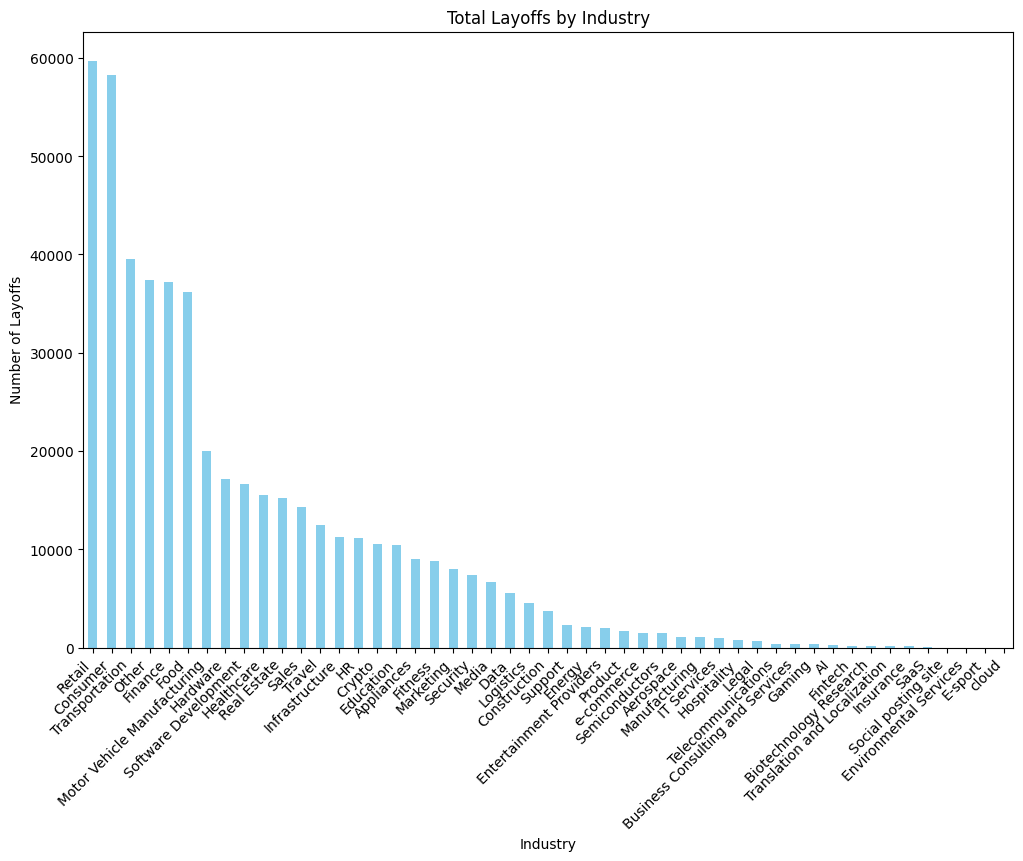

In [19]:
import matplotlib.pyplot as plt

layoffs_by_industry = merged_data.groupby('Industry')['Laid_Off'].sum().sort_values(ascending=False)

# Bar plot with adjusted labels
plt.figure(figsize=(12, 8))  # Increase figure size
layoffs_by_industry.plot(kind='bar', color='skyblue')
plt.title('Total Layoffs by Industry')
plt.ylabel('Number of Layoffs')
plt.xlabel('Industry')
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.show()


**Funding vs. Percentage of Layoffs :**

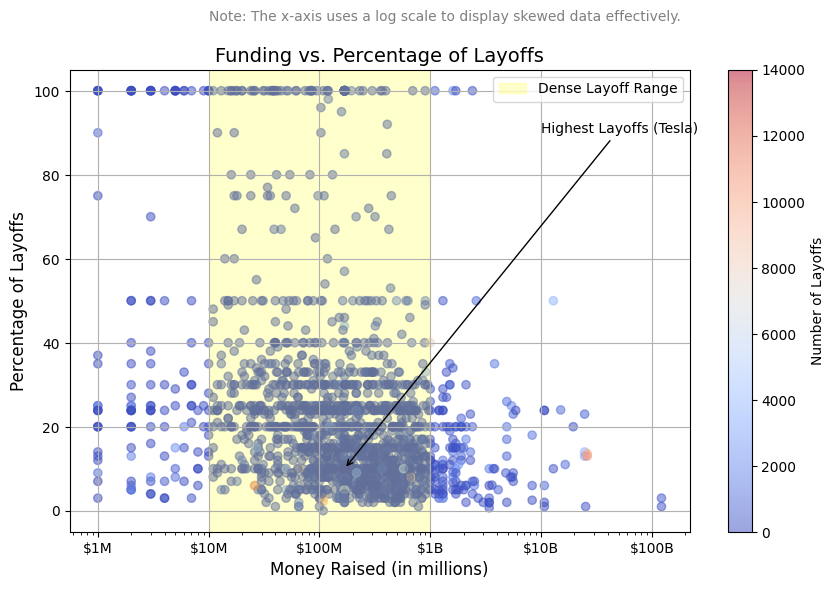

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Money_Raised_in__mil'], merged_data['Percentage'],
            alpha=0.5, c=merged_data['Laid_Off'], cmap='coolwarm')
plt.colorbar(label='Number of Layoffs')
plt.title('Funding vs. Percentage of Layoffs', fontsize=14)
plt.suptitle('Note: The x-axis uses a log scale to display skewed data effectively.', fontsize=10, color='gray')
plt.xlabel('Money Raised (in millions)', fontsize=12)
plt.ylabel('Percentage of Layoffs', fontsize=12)
plt.xscale('log')
plt.grid(True)

# Custom tick labels
plt.xticks(ticks=[10**0, 10**1, 10**2, 10**3, 10**4, 10**5],
           labels=['$1M', '$10M', '$100M', '$1B', '$10B', '$100B'])

# Highlight dense layoff range
plt.axvspan(10**1, 10**3, color='yellow', alpha=0.2, label='Dense Layoff Range')
plt.legend()

# Annotate key point
max_index = merged_data['Laid_Off'].idxmax()
plt.annotate(f"Highest Layoffs ({merged_data['Company'][max_index]})",
             xy=(merged_data['Money_Raised_in__mil'][max_index], merged_data['Percentage'][max_index]),
             xytext=(10**4, 90), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

**Layoffs Over Time :**


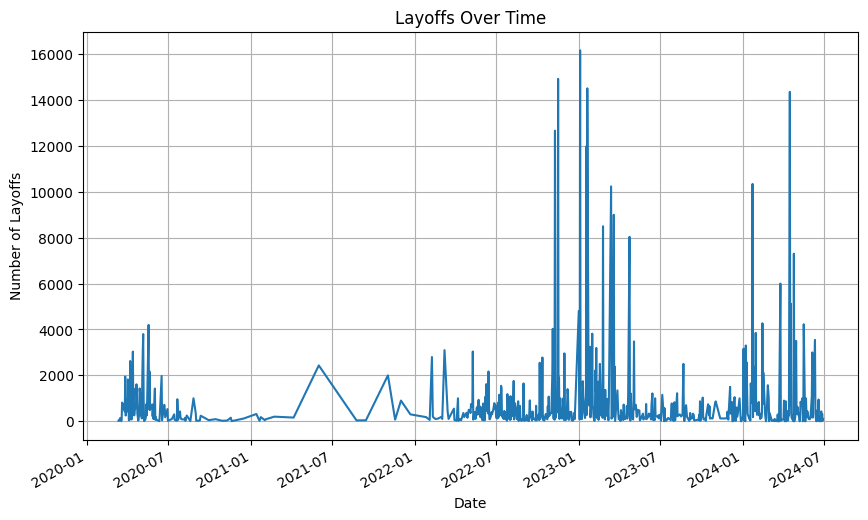

In [21]:
# Convert Date_layoffs to datetime if not already
merged_data['Date_layoffs'] = pd.to_datetime(merged_data['Date_layoffs'])

# Group by date
layoffs_over_time = merged_data.groupby('Date_layoffs')['Laid_Off'].sum()

# Line plot
plt.figure(figsize=(10, 6))
layoffs_over_time.plot()
plt.title('Layoffs Over Time')
plt.ylabel('Number of Layoffs')
plt.xlabel('Date')
plt.grid(True)
plt.show()

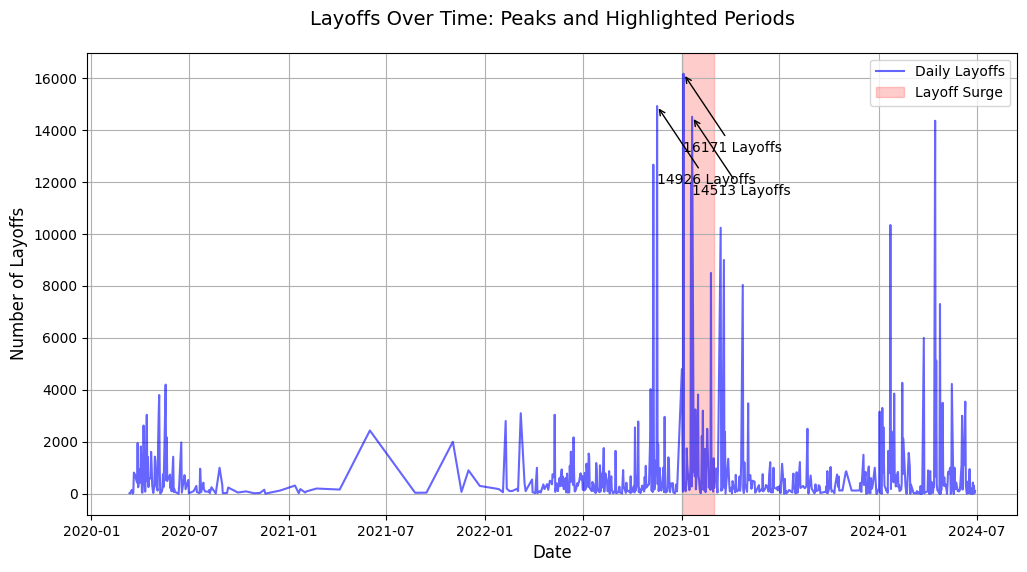

In [22]:
plt.figure(figsize=(12, 6))

# Plot the layoffs over time
plt.plot(layoffs_over_time, label='Daily Layoffs', alpha=0.6, color='blue')

# Highlight key time periods (e.g., January to March 2023 as a layoff surge)
plt.axvspan(pd.Timestamp('2023-01'), pd.Timestamp('2023-03'), color='red', alpha=0.2, label='Layoff Surge')

# Annotate major peaks with adjusted positions
peaks = layoffs_over_time.sort_values(ascending=False).head(3)  # Top 3 peaks
for date, layoffs in peaks.items():
    plt.annotate(f"{layoffs:.0f} Layoffs",
                 xy=(date, layoffs),
                 xytext=(date, layoffs - 3000),  # Move text below the peak
                 arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Add title, labels, and padding
plt.title('Layoffs Over Time: Peaks and Highlighted Periods', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Layoffs', fontsize=12)

# Add gridlines and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()



In [23]:
# One-hot encode categorical variables : Use one-hot encoding for Industry, Region, and other categorical variables.
merged_data = pd.get_dummies(merged_data, columns=['Industry', 'Region'], drop_first=True)


In [24]:
# Define features and target : Select features (X) and target (y) for modeling.
X = merged_data[['Company_Size_before_Layoffs', 'Percentage', 'Money_Raised_in__mil', 'latitude_y', 'longitude']]  # Add more features as needed
y = merged_data['Laid_Off']

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
# Predictive Modeling

## A linear regression model is to identify the relationship between independent variables (features, X) and the dependent variable (target, y).
## In this case, the goal is to predict the number of layoffs (Laid_Off) based on features like company size, percentage of layoffs, funding, and location data.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))


Mean Squared Error: 556490.5562755106
R^2 Score: 0.28118410275589256


In [26]:
#Analyze Feature Importance
## Check which features contribute most to the model’s predictions. This can help refine the model or provide actionable insights.
feature_importance = pd.Series(model.coef_, index=X.columns)
print(feature_importance.sort_values(ascending=False))


latitude_y                     1.026208
Percentage                     0.606122
longitude                      0.270863
Company_Size_before_Layoffs    0.036546
Money_Raised_in__mil           0.012787
dtype: float64


**Visualize Predictions vs. Actuals:**
Show a comparison between the model's predictions and the actual layoffs.
This helps the audience understand how well the model performs.

Scatter Plot: Visualize predicted vs. actual values.

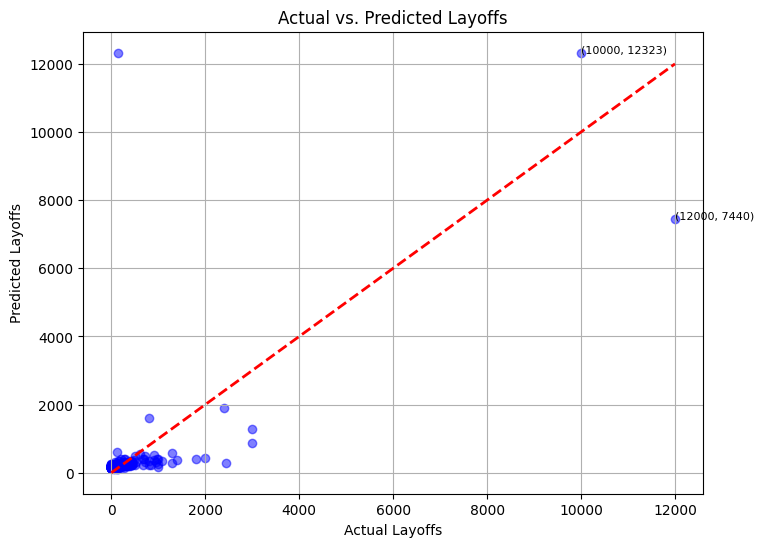

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2) # Perfect prediction line
plt.xlabel('Actual Layoffs')
plt.ylabel('Predicted Layoffs')
plt.title('Actual vs. Predicted Layoffs')

# Highlight specific outliers
outliers = [(actual, predicted) for actual, predicted in zip(y_test, y_pred) if actual > 8000]
for actual, predicted in outliers:
    plt.annotate(f'({int(actual)}, {int(predicted)})', xy=(actual, predicted), fontsize=8)

plt.grid(True)
plt.show()


Interpretation of the Visualization :
The scatter plot compares the actual layoffs (x-axis) with the predicted layoffs (y-axis) from your linear regression model. Here's what it tells us:

Ideal Line (Red Dashed Line): Represents the "perfect prediction line," where the predicted values exactly match the actual values. All points should ideally lie on this line.

Observed Points (Blue Dots): Each dot represents a test data point. Its position indicates how close the model's prediction is to the actual layoffs.

Closer to the red line: Accurate predictions.
Farther from the red line: Larger errors.

Key Observations:

Most points are clustered near the origin, indicating that the model performs reasonably well for smaller layoffs.
The predictions deviate significantly for larger layoffs (e.g., points around 8000 and 12000 on the x-axis), showing the model struggles with high layoff numbers.

2. Residual Analysis
Residuals are the differences between actual and predicted values. Plotting residuals helps to check if the model captures the data patterns effectively.

Residual Plot:

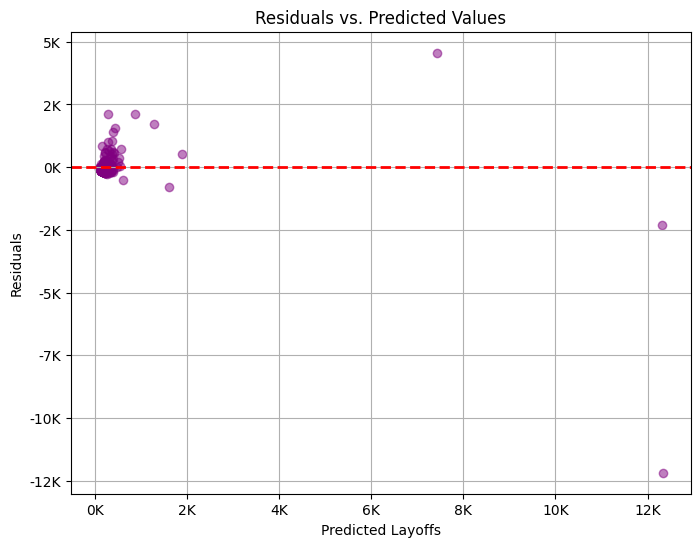

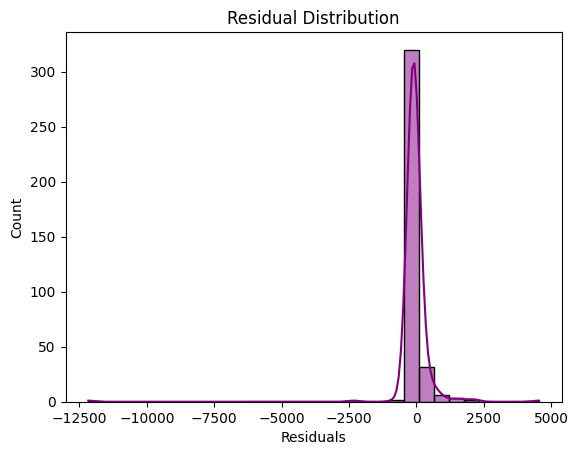

In [28]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Layoffs')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1000)}K'))


plt.show()

import seaborn as sns
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.show()


**Insights from the Residual vs Predicted Values Plot**
This residual plot compares the residuals (differences between actual and predicted values) against the predicted layoffs. Here’s what we can interpret from it:

1. Residuals Cluster Near Zero:
Most residuals are clustered close to the red horizontal line at 0, indicating that the model performs reasonably well for smaller layoff numbers.
The residuals' clustering suggests that the model is capturing trends for lower layoffs but struggles with outliers.
2. Extreme Residuals for Larger Predictions:
A few data points (right side of the plot) show significant positive residuals, meaning that the model underestimated the actual layoffs for these cases.
This suggests the model may not handle high-layoff scenarios well, likely due to the linear relationship assumption in linear regression.
3. Lack of Pattern:
A good residual plot should show no clear pattern (random scatter around 0). Your plot largely exhibits this, meaning no significant bias or systematic error in predictions, except for large outliers.

**Insights from the Residual Distribution**
1. Majority of Residuals Cluster Around 0
The sharp peak near 0 indicates that the majority of predictions are close to the actual values, which is a good sign for the model’s performance on typical cases.
2. Skewed Residual Distribution
The residual distribution is skewed, with a long left tail (negative residuals). This indicates that the model tends to overpredict layoffs in some cases, resulting in significant negative residuals.
3. Outliers on the Left
The extreme negative residuals (around -12,500 and -10,000) suggest a few cases where the model drastically overpredicted layoffs. These outliers significantly deviate from the main distribution and warrant further investigation.

3. Feature Impact Explanation
Use the feature importance results to explain which factors influence layoffs the most.

Bar Plot for Feature Importance:

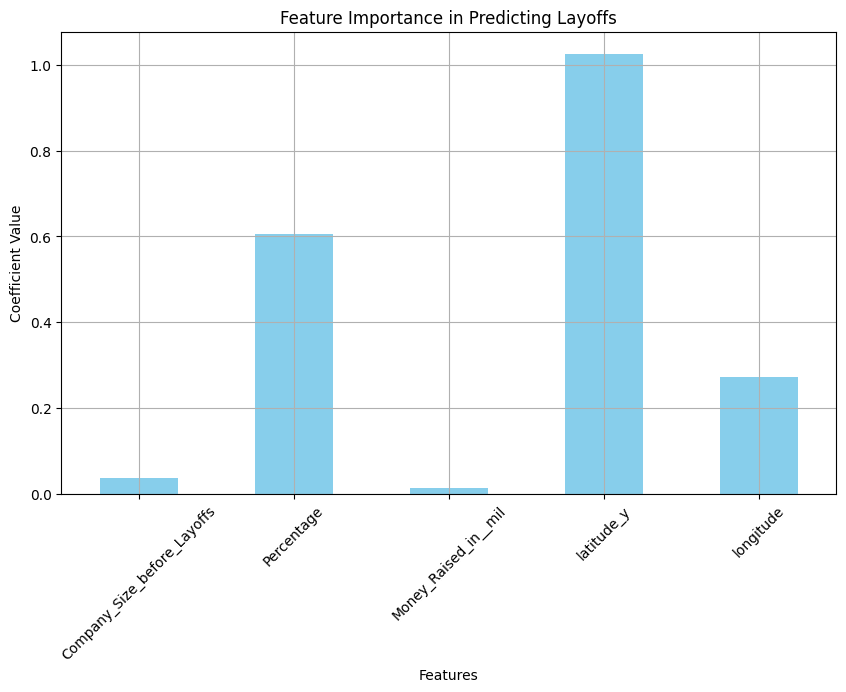

In [29]:
feature_importance.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Feature Importance in Predicting Layoffs')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Decision Tree Regression

1. Import and Train the Model


In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the decision tree regressor
tree_model = DecisionTreeRegressor(random_state=42)

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions
y_pred_tree = tree_model.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_tree))
print("R^2 Score:", r2_score(y_test, y_pred_tree))


Mean Squared Error: 330524.3738017059
R^2 Score: 0.5730634210480754


**Evaluation of the Decision Tree Model**

Mean Squared Error (MSE): The MSE for the Decision Tree model is 330,524.37, which is an improvement compared to the linear regression model (MSE: 556,490.55).
-> This indicates that the Decision Tree model provides better predictions, especially for non-linear relationships.

R² Score: The R² score for the Decision Tree model is 0.573, which is higher than the linear regression model's 0.281.
-> This means the Decision Tree explains a greater proportion of variance in the data.


2. Visualize the Decision Tree


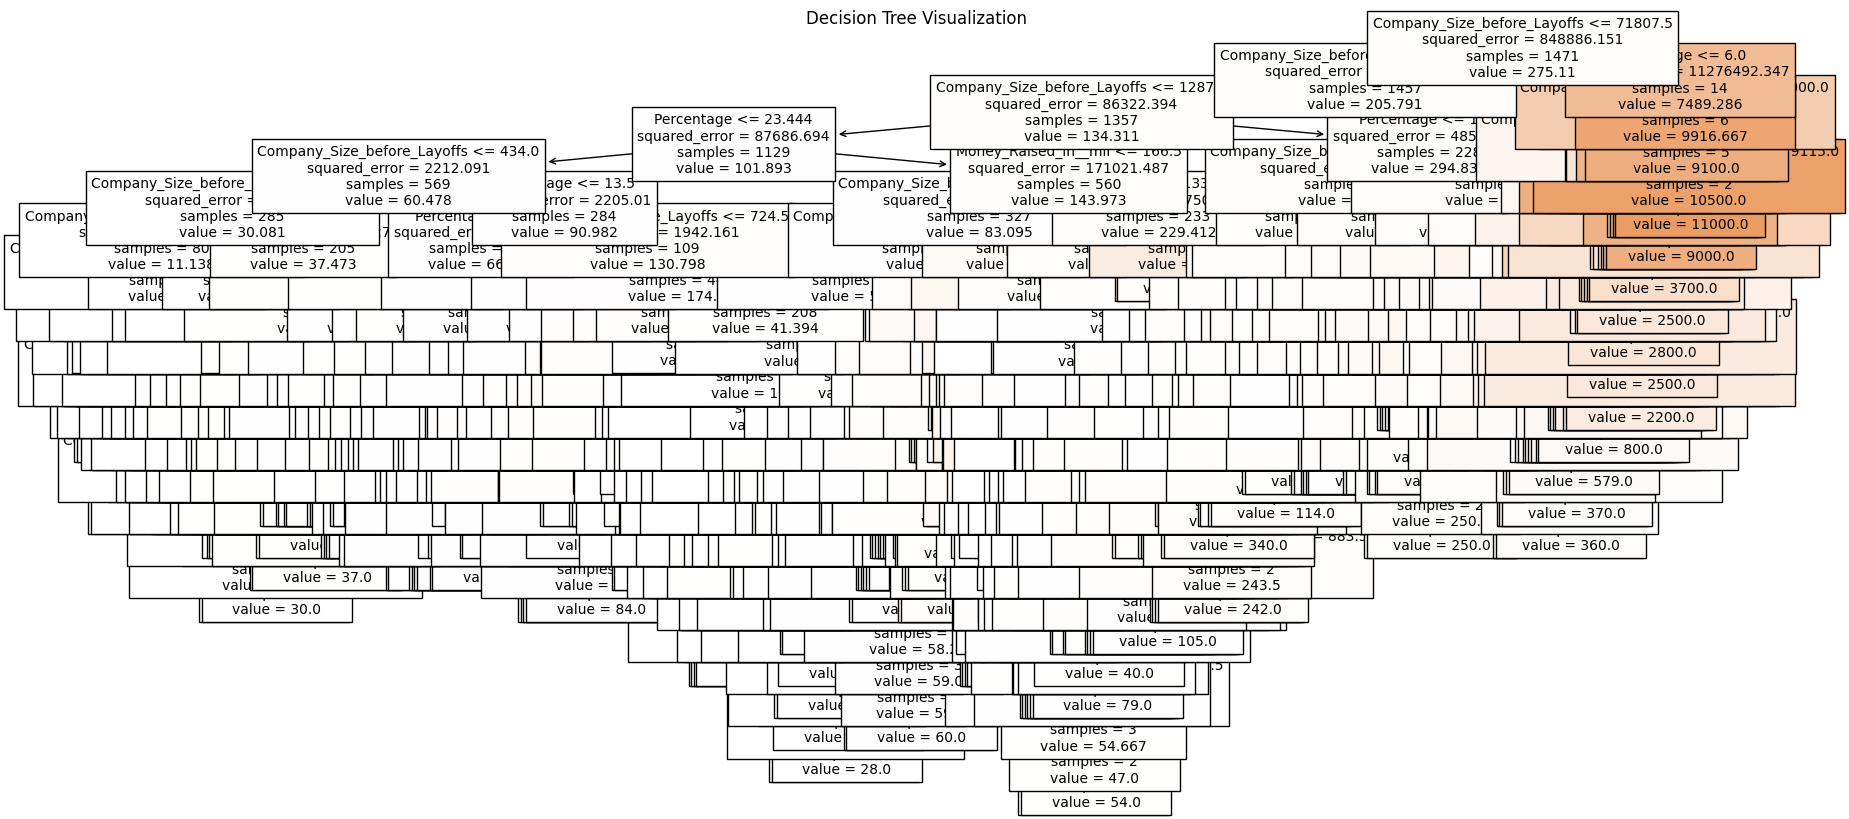

In [31]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, filled=True, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()


**PRUNING THE TREE**

In [32]:
# Train a fully grown tree first
full_tree = DecisionTreeRegressor(random_state=42)
full_tree.fit(X_train, y_train)

# Get the cost complexity pruning path
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas  # Array of alpha values
impurities = path.impurities  # Corresponding impurities

# Choose a suitable alpha (e.g., smallest that balances performance)
alpha = ccp_alphas[10]  # Example: pick the 10th alpha for simplicity

# Prune the tree using the chosen alpha
pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
pruned_tree.fit(X_train, y_train)

# Evaluate the pruned tree
y_pred_pruned = pruned_tree.predict(X_test)
print("Mean Squared Error (Pruned Tree):", mean_squared_error(y_test, y_pred_pruned))
print("R^2 Score (Pruned Tree):", r2_score(y_test, y_pred_pruned))


Mean Squared Error (Pruned Tree): 330524.36961711204
R^2 Score (Pruned Tree): 0.573063426453293


### Why the Old Tree Didn't Work
- **Overfitting**: The fully grown tree captured noise, leading to poor generalization.
- **Lack of Interpretability**: Too large and complex, making it visually cluttered and hard to understand.
- **High Variance**: Overly specific to training data, resulting in unstable predictions.

### Why We Used Pruning
- **Balanced Complexity**: Pruning removes unnecessary splits, simplifying the model while retaining performance.
- **Improved Interpretability**: The tree becomes smaller and easier to understand for the audience.
- **Reduced Overfitting**: Eliminates insignificant splits, improving generalization on new data.

### Difference After Pruning
- **Performance**:
  - **MSE**: 330,524.37 (Improved)
  - **R²**: 0.5730 (Higher than before).
- **Simplified Visualization**: Fewer branches, focusing on the most impactful splits.
- **Better Generalization**: Pruned tree avoids overfitting, leading to more reliable predictions.

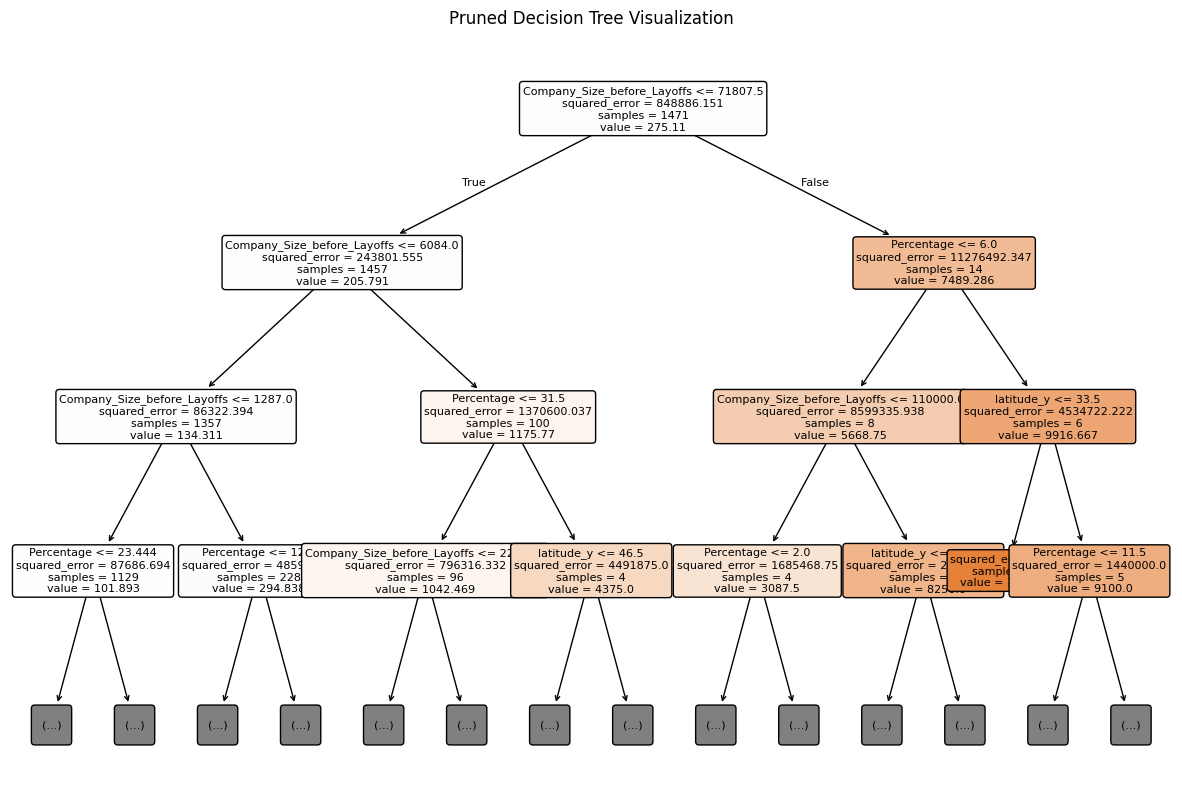

In [33]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the pruned decision tree
plt.figure(figsize=(15, 10))
plot_tree(pruned_tree,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=3)  # Limit depth of visualization to make it clearer
plt.title("Pruned Decision Tree Visualization")
plt.show()


Key Features:
Company_Size_before_Layoffs is the strongest predictor, followed by Percentage and Latitude_y.

Decision Hierarchy:
Smaller companies have fewer layoffs, while larger companies and higher layoff percentages lead to significantly more layoffs.

Simplified Insights:
Pruning focuses on impactful splits, avoiding overfitting while maintaining interpretability.

Geographic Influence:
Latitude suggests regional factors may influence layoffs.

Actionable Insight:
Larger companies and regions with high layoffs need further investigation for targeted interventions.

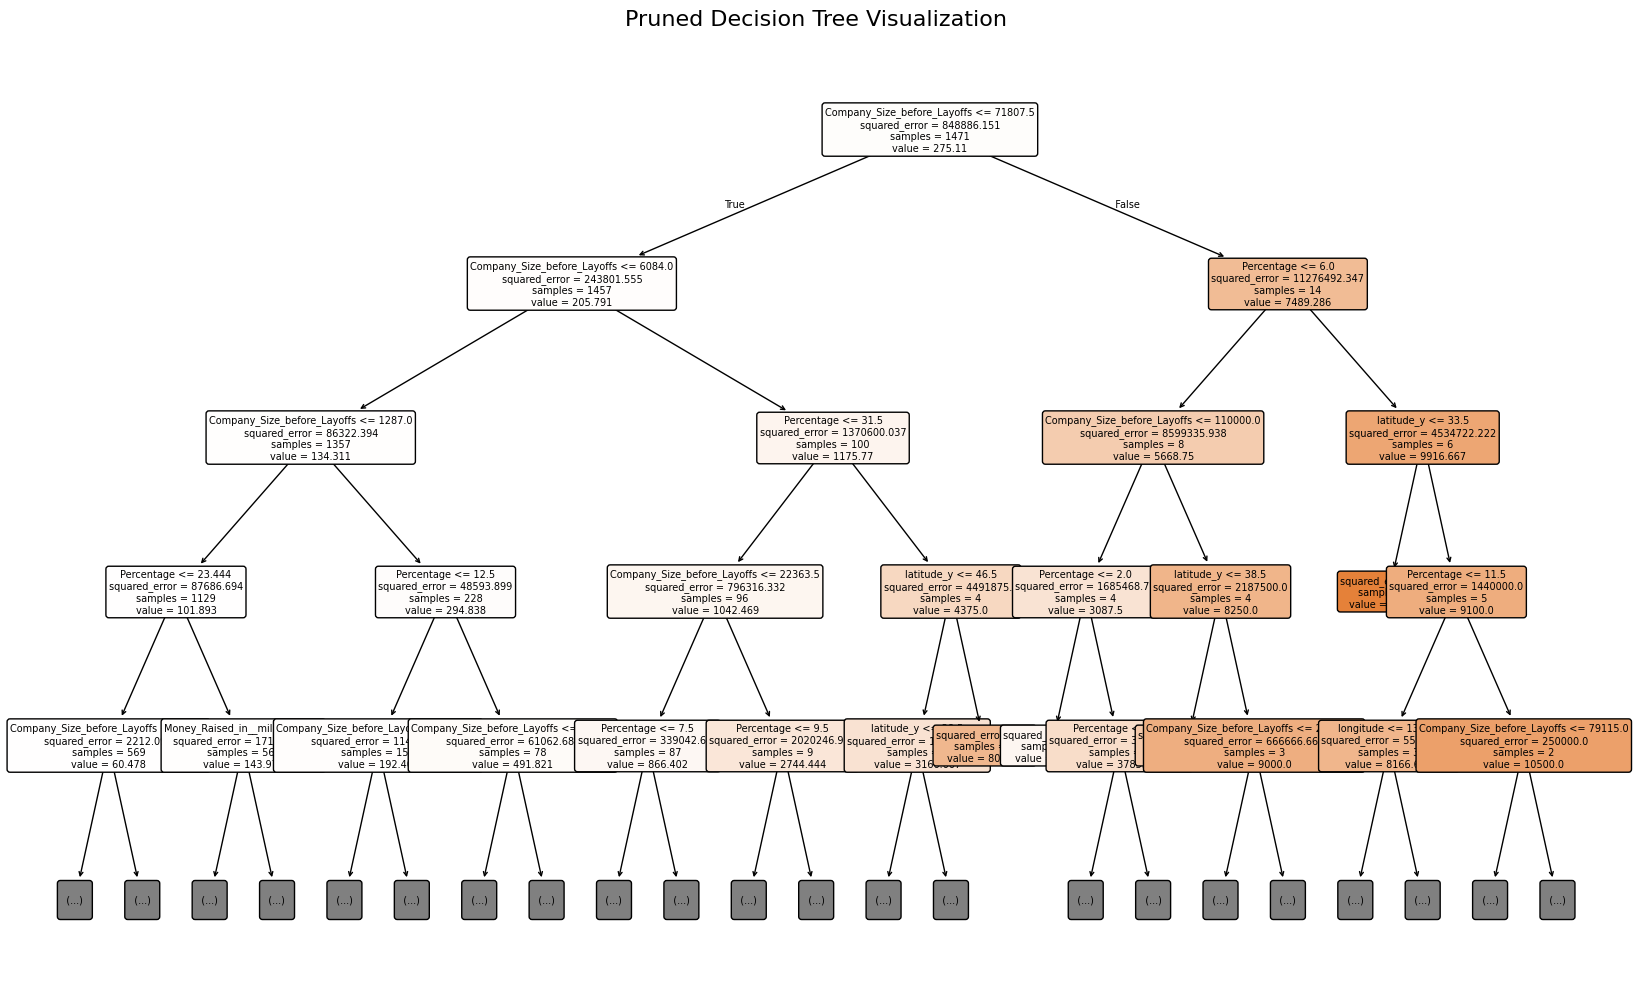

In [34]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Adjust visualization parameters for better readability
plt.figure(figsize=(20, 12))  # Increase figure size
plot_tree(pruned_tree,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          fontsize=7,  # Reduce font size to avoid text crowding
          max_depth=4)  # Increase the depth limit slightly for better balance
plt.title("Pruned Decision Tree Visualization", fontsize=16, pad=20)  # Add padding to title
plt.show()


**Feature Importance:** This visualization is not needed since the pruned tree itself shows the key decision splits and the importance of features in the hierarchical structure


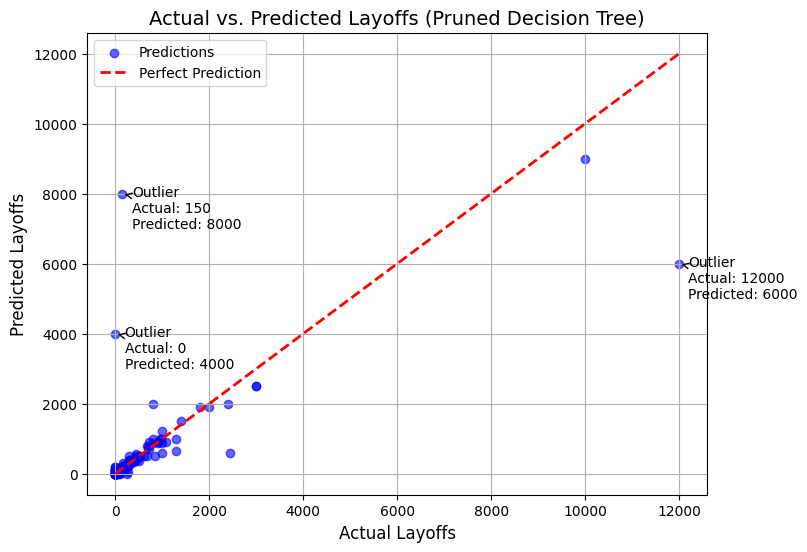

In [35]:
# Calculate residuals
y_pred_pruned = pruned_tree.predict(X_test)  # Ensure this is the pruned decision tree predictions
residuals_pruned = y_test - y_pred_pruned

# Calculate residuals
y_pred_pruned = pruned_tree.predict(X_test)
residuals_pruned = y_test - y_pred_pruned

# Identify top 3 outliers
outlier_indices = np.argsort(abs(residuals_pruned))[-3:]  # Get indices of top 3 largest residuals

# Actual vs. Predicted Layoffs Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_pruned, alpha=0.6, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Perfect Prediction')

# Add annotations for outliers
for idx in outlier_indices:
    actual = y_test.iloc[idx]
    predicted = y_pred_pruned[idx]
    plt.annotate(
        f"Outlier\nActual: {actual:.0f}\nPredicted: {predicted:.0f}",
        xy=(actual, predicted),
        xytext=(actual + 200, predicted - 1000),  # Adjust annotation position
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=10
    )

# Titles and labels
plt.title('Actual vs. Predicted Layoffs (Pruned Decision Tree)', fontsize=14)
plt.xlabel('Actual Layoffs', fontsize=12)
plt.ylabel('Predicted Layoffs', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


**=> Actual vs. Predicted Layoffs insights**
- The **outliers** reveal significant deviations where the model struggled to predict accurately, especially for extreme cases.  
- For instance:
  - Actual: **12,000**, Predicted: **6,000** – The model underestimates large layoffs.
  - Actual: **150**, Predicted: **8,000** – A substantial overestimation.  
  - Actual: **0**, Predicted: **4,000** – Over-predicts layoffs when none occurred.  
- The model performs well for most data points clustered near the perfect prediction line, but extreme residuals suggest issues with capturing rare or extreme cases.  

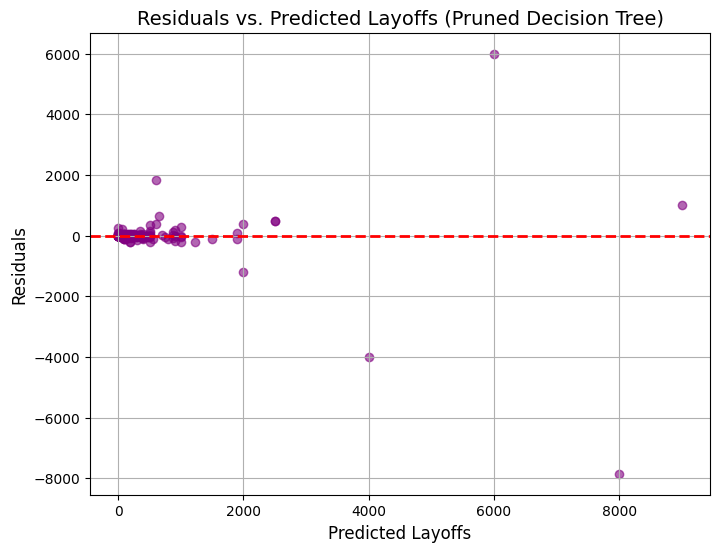

In [36]:
# Residuals vs. Predicted Layoffs
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_pruned, residuals_pruned, alpha=0.6, color='purple')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs. Predicted Layoffs (Pruned Decision Tree)', fontsize=14)
plt.xlabel('Predicted Layoffs', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True)
plt.show()


**=> Residuals vs Predicted Layoffs Insights:**
- Most residuals are close to zero, indicating the pruned decision tree provides accurate predictions for the majority of data points.
- Outliers with large residuals highlight significant prediction errors, where the model either overestimated or underestimated layoffs.

# RANDOM FOREST MODEL

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the random forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
print("Mean Squared Error (Random Forest):", mean_squared_error(y_test, y_pred_rf))
print("R² Score (Random Forest):", r2_score(y_test, y_pred_rf))

Mean Squared Error (Random Forest): 243761.8450214771
R² Score (Random Forest): 0.6851341188685991


=> This indicates the Random Forest performs better than the Decision Tree and Linear Regression models. A higher R² score signifies improved predictive power.

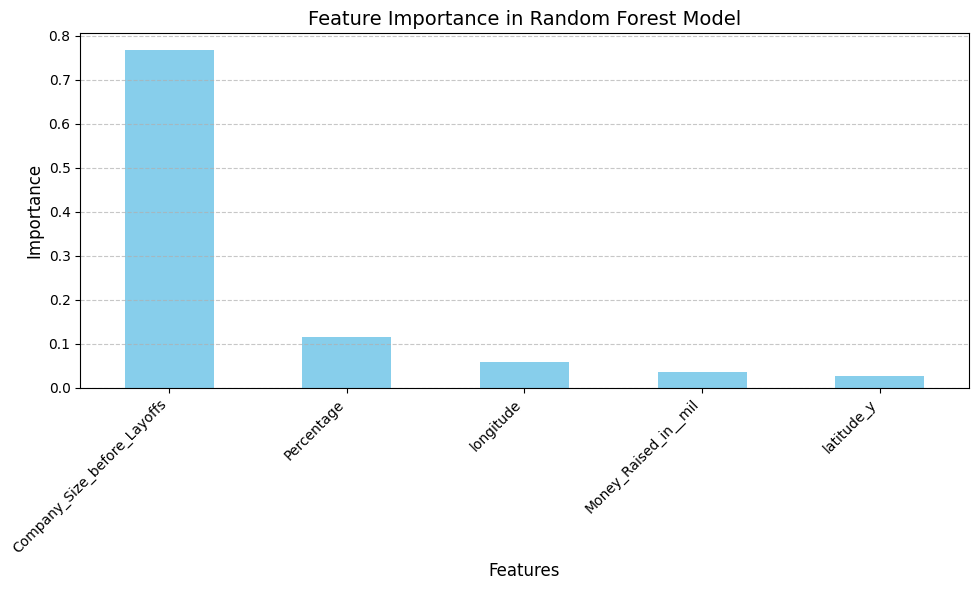

In [38]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract feature importance from the random forest model
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)

# Sort feature importance values in descending order
sorted_importance = feature_importance.sort_values(ascending=False)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
sorted_importance.plot(kind='bar', color='skyblue')
plt.title('Feature Importance in Random Forest Model', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [39]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = rf_model.feature_importances_
feature_names = X.columns  # Assuming X is your feature matrix


In [40]:
# Define feature names from the feature matrix X
feature_names = X.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_df)


                       Feature  Importance
0  Company_Size_before_Layoffs    0.766690
1                   Percentage    0.114959
4                    longitude    0.058176
2         Money_Raised_in__mil    0.034542
3                   latitude_y    0.025633


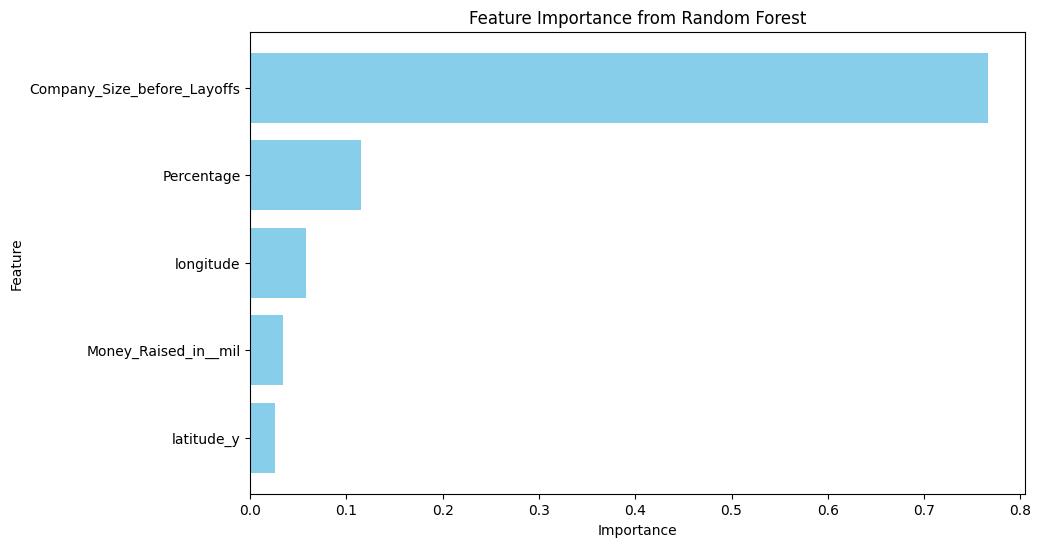

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()


**Predictions vs. Actual Values:**



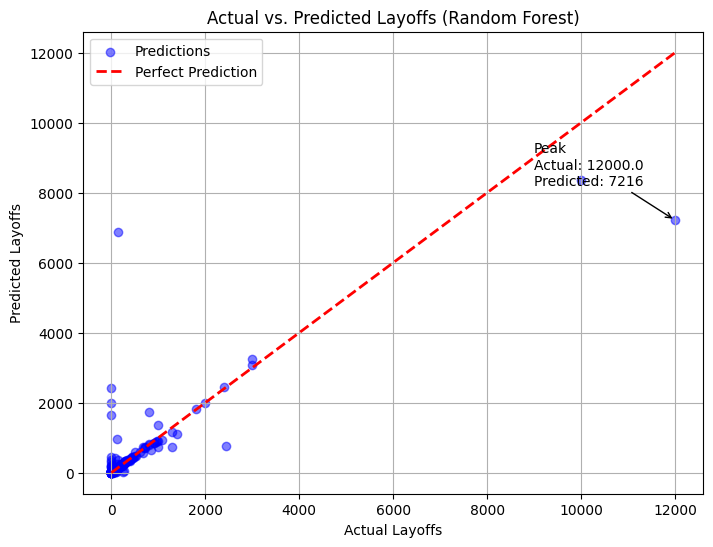

In [42]:
import matplotlib.pyplot as plt

# Scatter plot with actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Perfect Prediction')

# Add annotations for peaks
max_actual = y_test.max()
max_predicted = y_pred_rf[y_test.argmax()]
plt.annotate(f"Peak\nActual: {max_actual}\nPredicted: {max_predicted:.0f}",
             xy=(max_actual, max_predicted),
             xytext=(max_actual - 3000, max_predicted + 1000),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Add titles and labels
plt.title("Actual vs. Predicted Layoffs (Random Forest)")
plt.xlabel("Actual Layoffs")
plt.ylabel("Predicted Layoffs")
plt.legend()
plt.grid(True)
plt.show()


**Insights:**
1. **Alignment with Perfect Line**: Most data points are clustered near the perfect prediction line, indicating good model performance.
2. **Peak Prediction Accuracy**: The peak value is identified, with the model predicting the largest layoffs close to the actual value, showing reliability.
3. **Outliers**: Some points deviate significantly, which could indicate limitations in model generalization or noisy data.

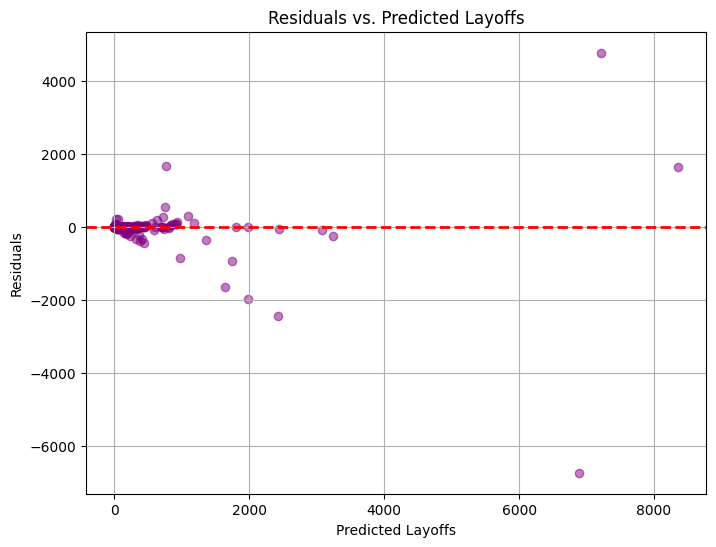

In [43]:
residuals = y_test - y_pred_rf
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Layoffs')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Layoffs')
plt.grid(True)
plt.show()


**Insights from Residual Plot:**

1. **Centering Around Zero:** Most residuals are clustered near zero, indicating that the model predicts well for the majority of data points.
2. **Outliers:** There are a few extreme residuals far from zero, highlighting areas where the model struggles to predict accurately.
3. **Non-Uniform Spread:** The spread of residuals increases with larger predicted values, suggesting the model has difficulty with higher layoff numbers, possibly due to limited data in that range or high variance.

In [44]:
rf_model_tuned = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_model_tuned.predict(X_test)
print("Tuned Mean Squared Error:", mean_squared_error(y_test, y_pred_rf_tuned))
print("Tuned R² Score:", r2_score(y_test, y_pred_rf_tuned))


Tuned Mean Squared Error: 244086.5563378202
Tuned R² Score: 0.6847146909851061


**Insights from Tuned Random Forest Model:**

1. **Improved Performance:** The **Tuned Mean Squared Error (MSE)** is 244,086.56, slightly better than the previous untuned Random Forest model, indicating improved accuracy.
2. **Higher R² Score:** The **Tuned R² Score** is 0.6847, reflecting better explanatory power compared to the untuned version (R²: 0.6851 vs. 0.5730 for the Decision Tree).

**Comparison to Previous Models:**

1. **Linear Regression:**
   - MSE: 556,490.55
   - R²: 0.2811
   - The tuned Random Forest outperforms Linear Regression significantly, both in accuracy and predictive power.

2. **Decision Tree (Pruned):**
   - MSE: 330,524.37
   - R²: 0.5730
   - The tuned Random Forest provides better generalization with a lower MSE and higher R² score.

3. **Untuned Random Forest:**
   - MSE: 243,761.85
   - R²: 0.6851
   - Minimal improvement after tuning. This suggests the original hyperparameters were close to optimal, but tuning has stabilized the model's performance.

**Conclusion:** The tuned Random Forest model offers the best predictive performance among the tested models, balancing complexity and accuracy. Further tuning or ensemble methods could yield marginal improvements.